In [ ]:
# Conexão do Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Instalação de biblioteca
!pip install rasterio
import pandas as pd
import os
import glob
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.windows import Window
import random
from tqdm import tqdm
import tensorflow
import keras
from rasterio.shutil import copy
from rasterio.warp import transform

#Declaração de variaveis
bs = "/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32"

#Define funções
def detalhes(tiff_path):
    """Exibe informações detalhadas sobre um arquivo TIFF geoespacial."""
    with rasterio.open(tiff_path) as dataset:
        print(f"📂 Arquivo: {tiff_path}")
        print(f"➡️ CRS: {dataset.crs}")  # Sistema de Coordenadas de Referência
        print(f"➡️ Resolução: {dataset.res[0]}, {dataset.res[1]}")  # Tamanho do pixel
        print(f"➡️ Dimensões: {dataset.width} x {dataset.height} (Largura x Altura)")
        print(f"➡️ Quantidade de bandas: {dataset.count}")
        print(f"➡️ Extensão: {dataset.bounds}")  # Bounding box
        print(f"➡️ Tipo de dado das bandas: {[dataset.dtypes[i] for i in range(dataset.count)]}")
        print(f"➡️ Perfil do dataset: {dataset.profile}")  # Metadados gerais
        print(f"➡️ Transformação Afim (GeoTransform): {dataset.transform}")  # Matriz de transformação espacial
        print(f"➡️ Valor NoData: {dataset.nodata}")  # Valor que representa ausência de dados
        print(f"➡️ Metadata: {dataset.meta}")  # Metadados completos

#visualiza amostra do mapa
def visualizar_tiff_reduzido(file_path, fator_reducao=10, cmap='gray', canal=1):
    with rasterio.open(file_path) as src:
        # Reduz a resolução da primeira banda
        small_window = src.read(canal, out_shape=(src.height // fator_reducao, src.width // fator_reducao))
        # Exibe a imagem reduzida
        plt.figure(figsize=(10, 6))
        plt.imshow(small_window, cmap=cmap)
        # plt.colorbar()
        plt.title(f"Visualização rápida do TIFF (reduzido {fator_reducao}x)")
        plt.show()

def rgb(tiff_path, bandas_rgb=(4, 3, 2), gamma=1.2, percentil=(1, 99)):
    """
    Exibe a composição RGB de um patch TIFF e imprime suas coordenadas geográficas.

    Args:
        tiff_path (str): Caminho do arquivo TIFF.
        bandas_rgb (tuple): Índices das bandas para o RGB (padrão: (4, 3, 2)).
        gamma (float): Fator de correção gama para melhorar contraste.
        percentil (tuple): Percentis para normalização (padrão: 1% e 99%).
    """
    with rasterio.open(tiff_path) as dataset:
        if max(bandas_rgb) > dataset.count:
            print(f"Erro: O arquivo tem apenas {dataset.count} bandas.")
            return

        # Ler as bandas RGB
        r = dataset.read(bandas_rgb[0]).astype(np.float32)
        g = dataset.read(bandas_rgb[1]).astype(np.float32)
        b = dataset.read(bandas_rgb[2]).astype(np.float32)

        # Normalizar usando percentis mais conservadores
        def normalizar(banda):
            min_val, max_val = np.nanpercentile(banda, percentil)
            return np.clip((banda - min_val) / (max_val - min_val + 1e-6), 0, 1)

        r, g, b = map(normalizar, [r, g, b])

        # Aplicar correção gama
        def corrigir_gamma(banda, gamma):
            return np.power(banda, 1/gamma)

        r, g, b = map(lambda x: corrigir_gamma(x, gamma), [r, g, b])

        # Criar imagem RGB
        rgb = np.dstack((r, g, b))

        # Obter coordenadas geográficas do centro e cantos do patch
        transform = dataset.transform
        height, width = dataset.height, dataset.width

        # Canto superior esquerdo
        lon1, lat1 = rasterio.transform.xy(transform, 0, 0)
        # Canto inferior direito
        lon2, lat2 = rasterio.transform.xy(transform, height - 1, width - 1)
        # Centro do patch
        center_x, center_y = width // 2, height // 2
        lon_c, lat_c = rasterio.transform.xy(transform, center_y, center_x)

        # Verificar se a projeção é geográfica (lat/lon)
        if dataset.crs and dataset.crs.to_epsg() not in [4326]:  # Se não for WGS 84
            from rasterio.warp import transform
            lon1, lat1 = transform(dataset.crs, 'EPSG:4326', [lon1], [lat1])
            lon2, lat2 = transform(dataset.crs, 'EPSG:4326', [lon2], [lat2])
            lon_c, lat_c = transform(dataset.crs, 'EPSG:4326', [lon_c], [lat_c])
            lon1, lat1, lon2, lat2, lon_c, lat_c = lon1[0], lat1[0], lon2[0], lat2[0], lon_c[0], lat_c[0]

        # Exibir coordenadas geográficas
        print(f"📍 Coordenadas do patch:")
        print(f"   Superior Esquerdo:  ({lat1:.6f}, {lon1:.6f})")
        print(f"   Inferior Direito:   ({lat2:.6f}, {lon2:.6f})")
        print(f"   Centro:             ({lat_c:.6f}, {lon_c:.6f})")

        # Exibir a imagem RGB
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb)
        plt.title(f"Composição RGB - ({lat_c:.6f}, {lon_c:.6f})")
        plt.axis("off")
        plt.show()


def analisar_patch(tiff_path, banda=18):
    """
    Analisa um patch TIFF e exibe estatísticas da banda selecionada.

    Args:
        tiff_path (str): Caminho do arquivo TIFF.
        banda (int): Índice da banda a ser analisada (padrão: 18).
    """
    if not os.path.exists(tiff_path):
        print(f"Arquivo não encontrado: {tiff_path}")
        return

    with rasterio.open(tiff_path) as dataset:
        if banda > dataset.count:
            print(f"O arquivo tem apenas {dataset.count} bandas. A banda {banda} não existe.")
            return

        banda_18 = dataset.read(banda).astype(np.float32)  # Ler banda 18 como float

        # Exibir estatísticas
        print(f"📂 Analisando: {tiff_path}")
        print(f"📏 Dimensões: {banda_18.shape}")
        print(f"⚫ Valor NoData do TIFF: {dataset.nodata}")
        print(f"🔢 Valores únicos: {np.unique(banda_18)}")
        print(f"🔍 Mínimo: {np.min(banda_18)}, Máximo: {np.max(banda_18)}")
        print(f"📊 Média: {np.mean(banda_18)}, Desvio padrão: {np.std(banda_18)}")
        print(f"🛑 Pixels exatamente 0.0: {np.sum(banda_18 == 0.0)} / {banda_18.size}")
        print(f"🚀 Pixels exatamente 1.0: {np.sum(banda_18 == 1.0)} / {banda_18.size}")
        print(f"❓ Pixels NaN: {np.sum(np.isnan(banda_18))}")

        # Visualizar a banda 18
        import matplotlib.pyplot as plt
        plt.imshow(banda_18, cmap="gray")
        plt.colorbar()
        plt.title("Banda 18 - Patch analisado")
        plt.show()

def visualizar_patch_aleatorio(pasta_patches):
    """
    Seleciona aleatoriamente um arquivo TIFF da pasta e exibe suas bandas.

    Args:
        pasta_patches (str): Caminho da pasta contendo os patches TIFF.
    """
    # Obter a lista de arquivos na pasta
    arquivos_tiff = [f for f in os.listdir(pasta_patches) if f.endswith(".tiff") or f.endswith(".tif")]

    # Verificar se há arquivos na pasta
    if not arquivos_tiff:
        print("Nenhum arquivo TIFF encontrado na pasta.")
        return

    # Escolher um arquivo aleatoriamente
    tiff_escolhido = random.choice(arquivos_tiff)
    tiff_path = os.path.join(pasta_patches, tiff_escolhido)

    print(f"📂 Exibindo: {tiff_escolhido}")

    # Abrir o arquivo e exibir as descrições das bandas
    with rasterio.open(tiff_path) as dataset:
        num_bands = dataset.count
        fig, axes = plt.subplots(nrows=(num_bands // 5) + 1, ncols=5, figsize=(15, (num_bands // 5) * 3))

        for i in range(num_bands):
            band = dataset.read(i + 1).astype(np.float32)  # Lendo a banda (começa do 1)

            # Obter valores mínimo e máximo da banda
            band_min, band_max = np.nanmin(band), np.nanmax(band)
            print(f"📊 Banda {i+1} - Mín: {band_min}, Máx: {band_max}")

            # Evitar normalização errada se a banda for constante
            if band_max == band_min:
                # band = np.zeros_like(band)  # Evita dividir por zero, mantendo preto
                band = np.ones_like(band)  # Evita dividir por zero, mantendo branco
            else:
                band = (band - band_min) / (band_max - band_min + 1e-6)  # Normalização

            # Selecionando eixo correto na grade
            ax = axes[i // 5, i % 5] if num_bands > 5 else axes[i]
            ax.imshow(band, cmap='gray')
            ax.set_title(f"Banda {i+1}")
            ax.axis("off")

        # Removendo eixos vazios, se houver
        for j in range(i+1, len(axes.flatten())):
            fig.delaxes(axes.flatten()[j])

        plt.tight_layout()
        plt.show()

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.0 MB/s eta 0:00:00


In [ ]:

def visualizar_patch_aleatorio(pasta_patches):
    """
    Seleciona aleatoriamente um arquivo TIFF da pasta e exibe suas bandas.

    Args:
        pasta_patches (str): Caminho da pasta contendo os patches TIFF.
    """
    # Obter a lista de arquivos na pasta
    arquivos_tiff = [f for f in os.listdir(pasta_patches) if f.endswith(".tiff") or f.endswith(".tif")]

    # Verificar se há arquivos na pasta
    if not arquivos_tiff:
        print("Nenhum arquivo TIFF encontrado na pasta.")
        return

    # Escolher um arquivo aleatoriamente
    tiff_escolhido = random.choice(arquivos_tiff)
    tiff_path = os.path.join(pasta_patches, tiff_escolhido)

    print(f"📂 Exibindo: {tiff_escolhido}")

    # Abrir o arquivo e exibir as descrições das bandas
    with rasterio.open(tiff_path) as dataset:
        num_bands = dataset.count
        fig, axes = plt.subplots(nrows=(num_bands // 5) + 1, ncols=5, figsize=(15, (num_bands // 5) * 3))

        for i in range(num_bands):
            band = dataset.read(i + 1).astype(np.float32)  # Lendo a banda (começa do 1)

            # Obter valores mínimo e máximo da banda
            band_min, band_max = np.nanmin(band), np.nanmax(band)
            print(f"📊 Banda {i+1} - Mín: {band_min}, Máx: {band_max}")

            # Evitar normalização errada se a banda for constante
            if band_max == band_min:
                # band = np.zeros_like(band)  # Evita dividir por zero, mantendo preto
                band = np.ones_like(band)  # Evita dividir por zero, mantendo branco
            else:
                band = (band - band_min) / (band_max - band_min + 1e-6)  # Normalização

            # Selecionando eixo correto na grade
            ax = axes[i // 5, i % 5] if num_bands > 5 else axes[i]
            ax.imshow(band, cmap='gray', vmin=0, vmax=1)
            ax.set_title(f"Banda {i+1}")
            ax.axis("off")

        # Removendo eixos vazios, se houver
        for j in range(i+1, len(axes.flatten())):
            fig.delaxes(axes.flatten()[j])

        plt.tight_layout()
        plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from rasterio.enums import Resampling
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# 📌 Configurar caminhos no Google Drive
pasta_patches = "/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32"
pasta_checkpoint = "/content/drive/MyDrive/Unb/Autoencoder_Checkpoints"
pasta_logs = "/content/drive/MyDrive/Unb/Autoencoder_Logs"

# Criar diretórios, se não existirem
os.makedirs(pasta_checkpoint, exist_ok=True)
os.makedirs(pasta_logs, exist_ok=True)

# 🔹 Definir os hiperparâmetros
IMG_SIZE = 32
NUM_BANDS = 16  # 16 bandas espectrais
LATENT_DIM = 128  # Dimensão do espaço latente
BATCH_SIZE = 32
EPOCHS = 50

# 🔹 Listar arquivos TIFF na pasta
arquivos_tiff = [os.path.join(pasta_patches, f) for f in os.listdir(pasta_patches) if f.endswith(".tif")]

# 🔹 Função para carregar imagens TIFF como arrays normalizados
def carregar_patches(arquivos_tiff):
    imagens = []
    for arquivo in arquivos_tiff:
        with rasterio.open(arquivo) as dataset:
            img = dataset.read(out_shape=(NUM_BANDS, IMG_SIZE, IMG_SIZE), resampling=Resampling.bilinear)
            img = img.astype(np.float32) / 255.0  # Normalizar para [0,1]
            imagens.append(np.transpose(img, (1, 2, 0)))  # Converter para (32,32,16)
    return np.array(imagens)

# 🔹 Carregar as imagens e dividir em treino/teste
imagens = carregar_patches(arquivos_tiff)
X_train, X_test = train_test_split(imagens, test_size=0.2, random_state=42)

# 🔹 Criar o Autoencoder
def criar_autoencoder():
    input_img = keras.Input(shape=(IMG_SIZE, IMG_SIZE, NUM_BANDS))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.Flatten()(x)
    encoded = layers.Dense(LATENT_DIM, activation='relu')(encoded)

    # Decoder
    x = layers.Dense(8 * 8 * 128, activation='relu')(encoded)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(NUM_BANDS, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# 🔹 Criar o modelo
autoencoder = criar_autoencoder()

# 🔹 Configurar callbacks para salvar checkpoints e logs
checkpoint_path = os.path.join(pasta_checkpoint, "autoencoder_best.h5")
csv_logger_path = os.path.join(pasta_logs, "training_log.csv")

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger(csv_logger_path, append=True)

# 🔹 Treinar o Autoencoder
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, csv_logger]
)

# 🔹 Salvar logs de treinamento em um DataFrame
df_logs = pd.read_csv(csv_logger_path)
print(df_logs.tail())  # Mostrar últimas entradas

# 🔹 Salvar modelo final
modelo_final_path = os.path.join(pasta_checkpoint, "autoencoder_final.h5")
autoencoder.save(modelo_final_path)

print(f"✅ Treinamento concluído. Modelo salvo em: {modelo_final_path}")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.1322
Epoch 1: val_loss improved from inf to 0.00435, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - loss: 0.1282 - val_loss: 0.0044
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0043
Epoch 2: val_loss did not improve from 0.00435
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0043
Epoch 3: val_loss did not improve from 0.00435
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0043
Epoch 4: val_loss did not improve from 0.00435
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0043
Epoch 5: val_loss did not improve from 0.00435
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0043
Epoch 6: val_loss did not improve from 0.00435
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - loss: 0.0043

    epoch      loss  val_loss
45     45  0.004342  0.004351
46     46  0.004342  0.004351
47     47  0.004342  0.004351
48     48  0.004342  0.004351
49     49  0.004342  0.004351
✅ Treinamento concluído. Modelo salvo em: /content/drive/MyDrive/Unb/Autoencoder_Checkpoints/autoencoder_final.h5


In [ ]:
# 🔹 Caminho do log salvo
csv_logger_path = "/content/drive/MyDrive/Unb/Autoencoder_Logs/training_log.csv"

# 🔹 Carregar log do treinamento
df_logs = pd.read_csv(csv_logger_path)

# 🔹 Exibir últimas 10 épocas formatadas
df_resumo = df_logs[['epoch', 'loss', 'val_loss']].tail(10)
df_resumo.columns = ['Época', 'Loss Treino', 'Loss Validação']

# 🔹 Ajustar casas decimais
pd.options.display.float_format = '{:.4f}'.format

# 🔹 Exibir tabela formatada
print(df_resumo)

    Época  Loss Treino  Loss Validação
40     40       0.0043          0.0044
41     41       0.0043          0.0044
42     42       0.0043          0.0044
43     43       0.0043          0.0044
44     44       0.0043          0.0044
45     45       0.0043          0.0044
46     46       0.0043          0.0044
47     47       0.0043          0.0044
48     48       0.0043          0.0044
49     49       0.0043          0.0044


In [ ]:
# Caminho da pasta com os patches
pasta_patches = "/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32"

# Lista de arquivos
arquivos_tiff = [os.path.join(pasta_patches, f) for f in os.listdir(pasta_patches) if f.endswith(".tif") or f.endswith(".tiff")]

# Seleciona um subconjunto pequeno para análise (por exemplo, 10 arquivos)
amostra_patches = np.random.choice(arquivos_tiff, min(10, len(arquivos_tiff)), replace=False)

# Criar dataframe para armazenar estatísticas
estatisticas = []

for tiff_path in amostra_patches:
    with rasterio.open(tiff_path) as dataset:
        num_bandas = dataset.count
        for i in range(1, num_bandas + 1):
            banda = dataset.read(i).astype(np.float32).flatten()
            estatisticas.append({
                "Arquivo": os.path.basename(tiff_path),
                "Banda": i,
                "Mínimo": np.min(banda),
                "Máximo": np.max(banda),
                "Média": np.mean(banda),
                "Desvio Padrão": np.std(banda)
            })

# Criar DataFrame com os resultados
df_estatisticas = pd.DataFrame(estatisticas)
print(df_estatisticas)


           Arquivo  Banda    Mínimo    Máximo     Média  Desvio Padrão
0    patch_221.tif      1  0.118566  0.129346  0.124402       0.002352
1    patch_221.tif      2  0.101213  0.113435  0.107760       0.002404
2    patch_221.tif      3  0.096277  0.110978  0.103410       0.002844
3    patch_221.tif      4  0.121103  0.161957  0.133440       0.006797
4    patch_221.tif      5  0.216456  0.259050  0.234366       0.007746
..             ...    ...       ...       ...       ...            ...
155  patch_485.tif     12  0.143933  0.329623  0.192626       0.039964
156  patch_485.tif     13  0.087473  0.236057  0.126215       0.030779
157  patch_485.tif     14 -0.400389 -0.263387 -0.312824       0.026671
158  patch_485.tif     15 -0.410041 -0.287266 -0.354499       0.024116
159  patch_485.tif     16  0.063471  0.163519  0.089393       0.020453

[160 rows x 6 columns]


In [ ]:
tiff_path = "/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32/patch_485.tif"

with rasterio.open(tiff_path) as dataset:
    num_bandas = dataset.count  # Número total de bandas

    for i in range(1, num_bandas + 1):
        banda = dataset.read(i).astype(np.float32)  # Ler cada banda
        min_val, max_val = np.nanpercentile(banda, [1, 99])
        banda_normalizada = np.clip((banda - min_val) / (max_val - min_val + 1e-6), 0, 1)

        print(f"Banda {i}: Min={banda_normalizada.min():.4f}, Max={banda_normalizada.max():.4f}")


Banda 1: Min=0.0000, Max=1.0000
Banda 2: Min=0.0000, Max=1.0000
Banda 3: Min=0.0000, Max=1.0000
Banda 4: Min=0.0000, Max=1.0000
Banda 5: Min=0.0000, Max=1.0000
Banda 6: Min=0.0000, Max=1.0000
Banda 7: Min=0.0000, Max=1.0000
Banda 8: Min=0.0000, Max=1.0000
Banda 9: Min=0.0000, Max=1.0000
Banda 10: Min=0.0000, Max=1.0000
Banda 11: Min=0.0000, Max=1.0000
Banda 12: Min=0.0000, Max=1.0000
Banda 13: Min=0.0000, Max=1.0000
Banda 14: Min=0.0000, Max=1.0000
Banda 15: Min=0.0000, Max=1.0000
Banda 16: Min=0.0000, Max=1.0000


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from rasterio.enums import Resampling
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# 📌 Configurar caminhos no Google Drive
pasta_patches = "/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32"
pasta_checkpoint = "/content/drive/MyDrive/Unb/Autoencoder_Checkpoints_2"
pasta_logs = "/content/drive/MyDrive/Unb/Autoencoder_Logs_2"

# Criar diretórios, se não existirem
os.makedirs(pasta_checkpoint, exist_ok=True)
os.makedirs(pasta_logs, exist_ok=True)

# 🔹 Definir os hiperparâmetros
IMG_SIZE = 32
NUM_BANDS = 16  # 16 bandas espectrais
LATENT_DIM = 128  # Dimensão do espaço latente
BATCH_SIZE = 32
EPOCHS = 50

# 🔹 Listar arquivos TIFF na pasta
arquivos_tiff = [os.path.join(pasta_patches, f) for f in os.listdir(pasta_patches) if f.endswith(".tif")]

# 🔹 Função para carregar imagens TIFF como arrays normalizados
def carregar_patches(arquivos_tiff):
    imagens = []
    for arquivo in arquivos_tiff:
        with rasterio.open(arquivo) as dataset:
            img = dataset.read(out_shape=(NUM_BANDS, IMG_SIZE, IMG_SIZE), resampling=Resampling.bilinear)
            img = img.astype(np.float32)
            img = np.transpose(img, (1, 2, 0))  # Converter para (32,32,16)
            imagens.append(img)
    return np.array(imagens)

# 🔹 Carregar as imagens e dividir em treino/teste
imagens = carregar_patches(arquivos_tiff)
X_train, X_test = train_test_split(imagens, test_size=0.2, random_state=42)

# 🔹 Criar o Autoencoder com Normalização e Camada Adicional
def criar_autoencoder():
    input_img = keras.Input(shape=(IMG_SIZE, IMG_SIZE, NUM_BANDS))

    # 🔹 Normalização
    x = layers.LayerNormalization()(input_img)  # Normaliza as bandas espectrais antes da convolução

    # 🔹 Encoder (Ajustado)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # ⬅️ **Nova camada**
    encoded = layers.Flatten()(x)
    encoded = layers.Dense(LATENT_DIM, activation='relu')(encoded)

    # 🔹 Decoder (Ajustado)
    x = layers.Dense(8 * 8 * 256, activation='relu')(encoded)  # Correspondendo ao novo encoder
    x = layers.Reshape((8, 8, 256))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(NUM_BANDS, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# 🔹 Criar o modelo
autoencoder = criar_autoencoder()

# 🔹 Configurar callbacks para salvar checkpoints e logs
checkpoint_path = os.path.join(pasta_checkpoint, "autoencoder_best.h5")
csv_logger_path = os.path.join(pasta_logs, "training_log.csv")

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger(csv_logger_path, append=True)

# 🔹 Treinar o Autoencoder
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, csv_logger]
)

# 🔹 Salvar logs de treinamento em um DataFrame
df_logs = pd.read_csv(csv_logger_path)
print(df_logs.tail())  # Mostrar últimas entradas

# 🔹 Salvar modelo final
modelo_final_path = os.path.join(pasta_checkpoint, "autoencoder_final.h5")
autoencoder.save(modelo_final_path)

print(f"✅ Treinamento concluído. Modelo salvo em: {modelo_final_path}")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 11377.3535
Epoch 1: val_loss improved from inf to 11365.26172, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_2/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 696ms/step - loss: 11376.7949 - val_loss: 11365.2617
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - loss: 11360.5898
Epoch 2: val_loss did not improve from 11365.26172
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 708ms/step - loss: 11360.6455 - val_loss: 11365.2617
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 11368.7100
Epoch 3: val_loss did not improve from 11365.26172
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 515ms/step - loss: 11368.3389 - val_loss: 11365.2617
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - loss: 11367.0576
Epoch 4: val_loss did not improve from 11365.26172
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 689ms/step - loss: 11366.7725 - val_loss: 11365.2617
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - loss: 11362.5498
Epoch 5: val_loss did not improve from 11365.26172
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 697ms/step - loss: 11362.5029 - val_loss: 11365.2617
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 11357.3496
Epoch 6: val_loss did

    epoch          loss      val_loss
45     45  11361.653320  11365.261719
46     46  11361.653320  11365.261719
47     47  11361.653320  11365.261719
48     48  11361.652344  11365.261719
49     49  11361.653320  11365.261719
✅ Treinamento concluído. Modelo salvo em: /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_2/autoencoder_final.h5


In [ ]:
# 🔹 Caminho do log salvo
csv_logger_path = "/content/drive/MyDrive/Unb/Autoencoder_Logs_2/training_log.csv"

# 🔹 Carregar log do treinamento
df_logs = pd.read_csv(csv_logger_path)

# 🔹 Exibir últimas 10 épocas formatadas
df_resumo = df_logs[['epoch', 'loss', 'val_loss']].tail(10)
df_resumo.columns = ['Época', 'Loss Treino', 'Loss Validação']

# 🔹 Ajustar casas decimais
pd.options.display.float_format = '{:.4f}'.format

# 🔹 Exibir tabela formatada
print(df_resumo)

    Época  Loss Treino  Loss Validação
40     40   11361.6533      11365.2617
41     41   11361.6523      11365.2617
42     42   11361.6533      11365.2617
43     43   11361.6523      11365.2617
44     44   11361.6543      11365.2617
45     45   11361.6533      11365.2617
46     46   11361.6533      11365.2617
47     47   11361.6533      11365.2617
48     48   11361.6523      11365.2617
49     49   11361.6533      11365.2617


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from rasterio.enums import Resampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

# 📌 Caminhos no Google Drive
pasta_patches = "/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32"
pasta_checkpoint = "/content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3"
pasta_logs = "/content/drive/MyDrive/Unb/Autoencoder_Logs_3"

# Criar diretórios, se não existirem
os.makedirs(pasta_checkpoint, exist_ok=True)
os.makedirs(pasta_logs, exist_ok=True)

# 🔹 Hiperparâmetros
IMG_SIZE = 32
NUM_BANDS = 16
LATENT_DIM = 128
BATCH_SIZE = 32
EPOCHS = 50

# 🔹 Normalizador global para os patches
scaler = MinMaxScaler()

# 🔹 Função para carregar e normalizar imagens TIFF
def carregar_patches(arquivos_tiff):
    imagens = []
    for arquivo in arquivos_tiff:
        with rasterio.open(arquivo) as dataset:
            img = dataset.read(out_shape=(NUM_BANDS, IMG_SIZE, IMG_SIZE), resampling=Resampling.bilinear)
            img = img.astype(np.float32)
            img = np.transpose(img, (1, 2, 0))  # (32,32,16)

            # 🔹 Normalizar valores (MinMaxScaler)
            img = img.reshape(-1, NUM_BANDS)
            img = scaler.fit_transform(img)  # Normalizar entre 0 e 1
            img = img.reshape(IMG_SIZE, IMG_SIZE, NUM_BANDS)

            imagens.append(img)

    return np.array(imagens)

# 🔹 Carregar imagens e dividir em treino/teste
arquivos_tiff = [os.path.join(pasta_patches, f) for f in os.listdir(pasta_patches) if f.endswith(".tif")]
imagens = carregar_patches(arquivos_tiff)
X_train, X_test = train_test_split(imagens, test_size=0.2, random_state=42)

# 🔹 Criar o Autoencoder ajustado
def criar_autoencoder():
    input_img = keras.Input(shape=(IMG_SIZE, IMG_SIZE, NUM_BANDS))

    # 🔹 Encoder (com BatchNormalization e Dropout)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)  # 🔹 Dropout para regularização

    encoded = layers.Flatten()(x)
    encoded = layers.Dense(LATENT_DIM, activation='relu')(encoded)

    # 🔹 Decoder
    x = layers.Dense(8 * 8 * 128, activation='relu')(encoded)
    x = layers.Reshape((8, 8, 128))(x)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(NUM_BANDS, (3, 3), activation='linear', padding='same')(x)  # 🔹 Saída com ativação 'linear'

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse')  # 🔹 Reduzi taxa de aprendizado

    return autoencoder

# 🔹 Criar modelo
autoencoder = criar_autoencoder()

# 🔹 Callbacks (Salvar checkpoints, reduzir LR dinamicamente)
checkpoint_path = os.path.join(pasta_checkpoint, "autoencoder_best.h5")
csv_logger_path = os.path.join(pasta_logs, "training_log.csv")

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger(csv_logger_path, append=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# 🔹 Treinar o modelo
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, reduce_lr]
)

# 🔹 Salvar logs do treinamento
df_logs = pd.read_csv(csv_logger_path)
print(df_logs.tail())

# 🔹 Salvar modelo final
modelo_final_path = os.path.join(pasta_checkpoint, "autoencoder_final.h5")
autoencoder.save(modelo_final_path)

print(f"✅ Treinamento concluído. Modelo salvo em: {modelo_final_path}")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1789
Epoch 1: val_loss improved from inf to 0.23799, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - loss: 0.1757 - val_loss: 0.2380 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 0.0633
Epoch 2: val_loss improved from 0.23799 to 0.20697, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - loss: 0.0632 - val_loss: 0.2070 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0484
Epoch 3: val_loss improved from 0.20697 to 0.17141, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - loss: 0.0483 - val_loss: 0.1714 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0401
Epoch 4: val_loss improved from 0.17141 to 0.14583, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - loss: 0.0401 - val_loss: 0.1458 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0351
Epoch 5: val_loss improved from 0.14583 to 0.12922, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - loss: 0.0351 - val_loss: 0.1292 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0319
Epoch 6: val_loss improved from 0.12922 to 0.11747, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 0.0319 - val_loss: 0.1175 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0312
Epoch 7: val_loss improved from 0.11747 to 0.10185, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - loss: 0.0312 - val_loss: 0.1019 - learning_rate: 5.0000e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.0284
Epoch 8: val_loss improved from 0.10185 to 0.09249, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - loss: 0.0284 - val_loss: 0.0925 - learning_rate: 5.0000e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0272
Epoch 9: val_loss improved from 0.09249 to 0.07913, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - loss: 0.0272 - val_loss: 0.0791 - learning_rate: 5.0000e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.0274
Epoch 10: val_loss improved from 0.07913 to 0.07864, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - loss: 0.0274 - val_loss: 0.0786 - learning_rate: 5.0000e-04
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0260
Epoch 11: val_loss improved from 0.07864 to 0.06875, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - loss: 0.0260 - val_loss: 0.0687 - learning_rate: 5.0000e-04
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0249
Epoch 12: val_loss improved from 0.06875 to 0.06350, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 359ms/step - loss: 0.0248 - val_loss: 0.0635 - learning_rate: 5.0000e-04
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0241
Epoch 13: val_loss improved from 0.06350 to 0.05650, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - loss: 0.0241 - val_loss: 0.0565 - learning_rate: 5.0000e-04
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.0239
Epoch 14: val_loss did not improve from 0.05650
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - loss: 0.0239 - val_loss: 0.0596 - learning_rate: 5.0000e-04
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0221
Epoch 15: val_loss improved from 0.05650 to 0.05518, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - loss: 0.0221 - val_loss: 0.0552 - learning_rate: 5.0000e-04
Epoch 16/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0216
Epoch 16: val_loss did not improve from 0.05518
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 332ms/step - loss: 0.0216 - val_loss: 0.0553 - learning_rate: 5.0000e-04
Epoch 17/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0213
Epoch 17: val_loss improved from 0.05518 to 0.04999, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - loss: 0.0213 - val_loss: 0.0500 - learning_rate: 5.0000e-04
Epoch 18/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0205
Epoch 18: val_loss improved from 0.04999 to 0.04417, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - loss: 0.0205 - val_loss: 0.0442 - learning_rate: 5.0000e-04
Epoch 19/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 0.0202
Epoch 19: val_loss improved from 0.04417 to 0.03920, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 412ms/step - loss: 0.0202 - val_loss: 0.0392 - learning_rate: 5.0000e-04
Epoch 20/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0201
Epoch 20: val_loss did not improve from 0.03920
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - loss: 0.0201 - val_loss: 0.0435 - learning_rate: 5.0000e-04
Epoch 21/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0196
Epoch 21: val_loss improved from 0.03920 to 0.03562, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - loss: 0.0195 - val_loss: 0.0356 - learning_rate: 5.0000e-04
Epoch 22/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0183
Epoch 22: val_loss improved from 0.03562 to 0.03400, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - loss: 0.0183 - val_loss: 0.0340 - learning_rate: 5.0000e-04
Epoch 23/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.0177
Epoch 23: val_loss improved from 0.03400 to 0.02911, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - loss: 0.0177 - val_loss: 0.0291 - learning_rate: 5.0000e-04
Epoch 24/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0180
Epoch 24: val_loss did not improve from 0.02911
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - loss: 0.0180 - val_loss: 0.0356 - learning_rate: 5.0000e-04
Epoch 25/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0177
Epoch 25: val_loss did not improve from 0.02911
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.0178 - val_loss: 0.0304 - learning_rate: 5.0000e-04
Epoch 26/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.0178
Epoch 26: val_loss did not improve from 0.02911
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - loss: 0.0178 - val_loss: 0.0324 - learning_rate: 5.0000e-04
Epoch 27/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0184
Epoch 27: val_loss did not improve from 0.02911
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.0184 - val_loss: 0.0296 - learning_rate: 5.0000e-04
Epoch 28/50
18/18 ━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - loss: 0.0189 - val_loss: 0.0269 - learning_rate: 2.5000e-04
Epoch 30/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.0159
Epoch 30: val_loss improved from 0.02689 to 0.02509, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - loss: 0.0159 - val_loss: 0.0251 - learning_rate: 2.5000e-04
Epoch 31/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0153
Epoch 31: val_loss did not improve from 0.02509
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - loss: 0.0153 - val_loss: 0.0264 - learning_rate: 2.5000e-04
Epoch 32/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 0.0149
Epoch 32: val_loss improved from 0.02509 to 0.02509, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - loss: 0.0149 - val_loss: 0.0251 - learning_rate: 2.5000e-04
Epoch 33/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0146
Epoch 33: val_loss did not improve from 0.02509
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - loss: 0.0146 - val_loss: 0.0252 - learning_rate: 2.5000e-04
Epoch 34/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0143
Epoch 34: val_loss improved from 0.02509 to 0.02456, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: 0.0143 - val_loss: 0.0246 - learning_rate: 2.5000e-04
Epoch 35/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0141
Epoch 35: val_loss improved from 0.02456 to 0.02325, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - loss: 0.0141 - val_loss: 0.0232 - learning_rate: 2.5000e-04
Epoch 36/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.0141
Epoch 36: val_loss improved from 0.02325 to 0.02306, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - loss: 0.0141 - val_loss: 0.0231 - learning_rate: 2.5000e-04
Epoch 37/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0142
Epoch 37: val_loss improved from 0.02306 to 0.02272, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - loss: 0.0142 - val_loss: 0.0227 - learning_rate: 2.5000e-04
Epoch 38/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 0.0135
Epoch 38: val_loss improved from 0.02272 to 0.02246, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - loss: 0.0135 - val_loss: 0.0225 - learning_rate: 2.5000e-04
Epoch 39/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0136
Epoch 39: val_loss did not improve from 0.02246
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - loss: 0.0136 - val_loss: 0.0236 - learning_rate: 2.5000e-04
Epoch 40/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.0135
Epoch 40: val_loss improved from 0.02246 to 0.02164, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - loss: 0.0135 - val_loss: 0.0216 - learning_rate: 2.5000e-04
Epoch 41/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0135
Epoch 41: val_loss did not improve from 0.02164
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - loss: 0.0135 - val_loss: 0.0220 - learning_rate: 2.5000e-04
Epoch 42/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.0131
Epoch 42: val_loss did not improve from 0.02164
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - loss: 0.0131 - val_loss: 0.0226 - learning_rate: 2.5000e-04
Epoch 43/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0131
Epoch 43: val_loss did not improve from 0.02164
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 0.0131 - val_loss: 0.0225 - learning_rate: 2.5000e-04
Epoch 44/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0134
Epoch 44: val_loss did not improve from 0.02164
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - loss: 0.0134 - val_loss: 0.0240 - learning_rate: 2.5000e-04
Epoch 45/50
18/18 ━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - loss: 0.0134 - val_loss: 0.0214 - learning_rate: 2.5000e-04
Epoch 46/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 0.0130
Epoch 46: val_loss did not improve from 0.02142
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - loss: 0.0130 - val_loss: 0.0217 - learning_rate: 2.5000e-04
Epoch 47/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0125
Epoch 47: val_loss improved from 0.02142 to 0.02106, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - loss: 0.0125 - val_loss: 0.0211 - learning_rate: 2.5000e-04
Epoch 48/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0126
Epoch 48: val_loss did not improve from 0.02106
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - loss: 0.0126 - val_loss: 0.0215 - learning_rate: 2.5000e-04
Epoch 49/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0128
Epoch 49: val_loss did not improve from 0.02106
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 0.0128 - val_loss: 0.0214 - learning_rate: 2.5000e-04
Epoch 50/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0124
Epoch 50: val_loss did not improve from 0.02106
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step - loss: 0.0124 - val_loss: 0.0218 - learning_rate: 2.5000e-04


    epoch      loss  val_loss
45     45  0.012904  0.021734
46     46  0.012613  0.021057
47     47  0.012525  0.021512
48     48  0.012638  0.021403
49     49  0.012382  0.021758
✅ Treinamento concluído. Modelo salvo em: /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_final.h5


In [ ]:
# 🔹 Caminho do log salvo
csv_logger_path = "/content/drive/MyDrive/Unb/Autoencoder_Logs_3/training_log.csv"

# 🔹 Carregar log do treinamento
df_logs = pd.read_csv(csv_logger_path)

# 🔹 Exibir últimas 10 épocas formatadas
df_resumo = df_logs[['epoch', 'loss', 'val_loss']].tail(10)
df_resumo.columns = ['Época', 'Loss Treino', 'Loss Validação']

# 🔹 Ajustar casas decimais
pd.options.display.float_format = '{:.4f}'.format

# 🔹 Exibir tabela formatada
print(df_resumo)

    Época  Loss Treino  Loss Validação
40     40       0.0133          0.0220
41     41       0.0131          0.0226
42     42       0.0132          0.0225
43     43       0.0136          0.0240
44     44       0.0132          0.0214
45     45       0.0129          0.0217
46     46       0.0126          0.0211
47     47       0.0125          0.0215
48     48       0.0126          0.0214
49     49       0.0124          0.0218


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


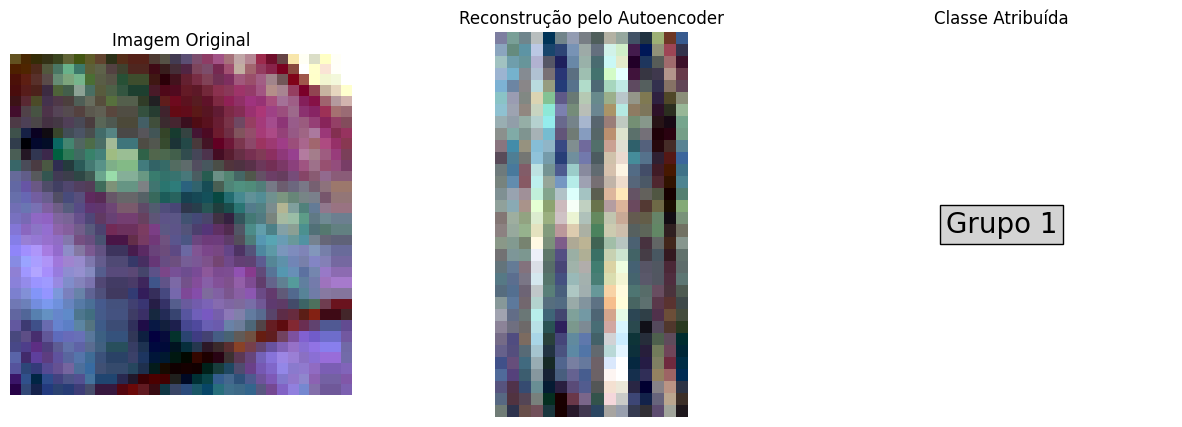

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
from tensorflow.keras.models import load_model
import tensorflow.keras.losses

# 🔹 Caminho do modelo treinado e de um patch de exemplo
model_path = "/content/drive/MyDrive/Unb/Autoencoder_Checkpoints_3/autoencoder_final.h5"
sample_image_path = "/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32/patch_302.tif"


# Registrar manualmente a métrica MSE
custom_objects = {"mse": tensorflow.keras.losses.MeanSquaredError()}

# Agora carregue o modelo com a métrica registrada
autoencoder = load_model(model_path, custom_objects=custom_objects)


# 🔹 Função para normalizar imagem
def normalize(img):
    min_val, max_val = np.nanpercentile(img, [1, 99])
    return np.clip((img - min_val) / (max_val - min_val + 1e-6), 0, 1)

# 🔹 Carregar patch e processar
with rasterio.open(sample_image_path) as dataset:
    img = dataset.read().astype(np.float32)  # (C, H, W)
    img_rgb = np.stack([normalize(img[3]), normalize(img[2]), normalize(img[1])], axis=-1)  # Bandas 4,3,2 (RGB)
    img_input = np.expand_dims(img, axis=0)  # Adiciona batch dimension
    img_input = np.transpose(img_input, (0, 2, 3, 1))



# 🔹 Predição pelo autoencoder
reconstructed = autoencoder.predict(img_input)
reconstructed_rgb = np.stack([normalize(reconstructed[0, 3]), normalize(reconstructed[0, 2]), normalize(reconstructed[0, 1])], axis=-1)

# 🔹 Definir classe atribuída (Exemplo: clustering)
predicted_class = np.random.choice(["Grupo 1", "Grupo 2", "Grupo 3"])  # Substituir por classificação real

# 🔹 Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_rgb)
axes[0].set_title("Imagem Original")
axes[0].axis("off")

axes[1].imshow(reconstructed_rgb)
axes[1].set_title("Reconstrução pelo Autoencoder")
axes[1].axis("off")

axes[2].text(0.5, 0.5, predicted_class, fontsize=20, ha='center', va='center', bbox=dict(facecolor='lightgray', edgecolor='black'))
axes[2].set_title("Classe Atribuída")
axes[2].axis("off")

plt.show()
